# **Part of Speech Tagging using Hidden Markov Models**



In this assignment, you are asked to train your **OWN** Hidden Markov Model to predict part of speech tags of words. Steps to the assignment:
1. Download the data from this link - both the web.conllu and wiki.conllu: https://github.com/google-research-datasets/turkish-treebanks/tree/master/data
1. We combined the web and the wiki to have a bigger dataset. Split this dataset (*sentences*) into train/test sets with 0.8/0.2 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Calculate the transition and emission probabilities using the Maximum Likelihood Estimation (MLE). You can use smoothing for transition and emission probabilities.
1. Train two HMMs with two sets of Part-of-Speech tags.

  a. All of the POS tags in the dataset. There are 14 POS tags in the dataset.

  b. Only the tags "ADJ, ADV, NOUN, VERB, PUNC"
1. Add the "\<START>" and "\<END>" tags for calculating the induction and ending probabilities.
1. Predict the tags for the test set using Viterbi algorithm with the trained HMM.
1. Evaluate the prediction with the gold labels. Show confusion matrix for the tags.
1. Compare the two versions of the HMMs in terms of accuracy and F1 score - all tags version, only "ADJ, ADV, NOUN, VERB, PUNC" version.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for anything **other than the HMM training and prediction**.
 - Use strategies to increase the performance like handling unknown or rare words, using a dictionary of open/closed words for prediction, changing smoothing functions, and others.
 - Adding additional coding blocks

### Not allowed:
 - **You need to write your own HMM.** Using the HMM model from an external library is not allowed.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Data preparation method
 - How did you calculate of MLE probabilities for transition and emission matrices?
 - Challenges you have faced while writing the HMM model and challenges with the specific dataset
 - Comments about the performance of your HMM tagger
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.5),
 - clear commenting (0.5),
 - data preparation (0.5),
 - HMM transition and emission probability calculation (2)
 - POS tagging the test data with trained HMM using Viterbi algorithm (2)
 - Evaluation of the performance of HMM POS tagger (1)
 - assignment report (1).

Total points for this assignment = 7.5

You can get bonus points (maximum 0.5) by trying extra methods to improve the performance of the HMM model.

## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_hmm_tagger.ipynb  - ex. 26744_aysegulrana_hmm_tagger.ipynb`


**Deadline is December 26th, 23.55pm.**


In [3]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip metadata lines starting with "#"
            if line.startswith("#"):
                continue

            # Sentence boundary (blank line)
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                # Split the line into columns and extract word and POS tag
                columns = line.split('\t')
                if len(columns) > 3:  # Check to ensure the line has expected columns
                    word = columns[2]
                    if word == '_':
                      continue

                    pos_tag = columns[3]
                    sentence.append((word, pos_tag))

        # Add the last sentence if the file doesn't end with a blank line
        if sentence:
            sentences.append(sentence)

    return sentences

# Usage
web_file_path = "web.conllu"
wiki_file_path = "wiki.conllu"

web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

sentences = web_sentences + wiki_sentences

In [4]:
sentences[0]

[('bur', 'PRON'),
 ('da', 'PRT'),
 ('öyle', 'VERB'),
 ('yoksa', 'CONJ'),
 ('kilo', 'VERB'),
 ('mı', 'PRT'),
 ('?', 'PUNCT')]

In [5]:
sentences

[[('bur', 'PRON'),
  ('da', 'PRT'),
  ('öyle', 'VERB'),
  ('yoksa', 'CONJ'),
  ('kilo', 'VERB'),
  ('mı', 'PRT'),
  ('?', 'PUNCT')],
 [('açık', 'NOUN'),
  ('soru', 'NOUN'),
  ('müfredat', 'NOUN'),
  ('uygun', 'ADJ'),
  ('ol', 'VERB'),
  ('ol', 'VERB'),
  ('bil', 'VERB'),
  ('imkan', 'NOUN'),
  ('.', 'PUNCT')],
 [('bakara', 'NOUN'),
  ('sure', 'NOUN'),
  ('248', 'NUM'),
  ('ayet', 'NOUN'),
  ('açık', 'NOUN'),
  ('mı', 'VERB'),
  ('?', 'PUNCT')],
 [('internet', 'NOUN'),
  ('araştır', 'VERB'),
  ('açık', 'NOUN'),
  ('cevap', 'NOUN'),
  ('bul', 'VERB'),
  ('.', 'PUNCT')],
 [('burun', 'NOUN'),
  ('kemik', 'NOUN'),
  ('herhangi', 'DET'),
  ('bir', 'DET'),
  ('eğri', 'NOUN'),
  ('ol', 'VERB'),
  ('için', 'ADP'),
  ('kemik', 'NOUN'),
  ('hiç', 'ADV'),
  ('dokun', 'VERB'),
  ('.', 'PUNCT')],
 [('(', 'PUNCT'),
  ('kod', 'NOUN'),
  ('19', 'NUM'),
  (')', 'PUNCT'),
  ("''", 'PUNCT'),
  ('şekil', 'NOUN'),
  ('bir', 'DET'),
  ('mesaj', 'NOUN'),
  ('al', 'VERB'),
  ('.', 'PUNCT')],
 [('kürtaj', 'NOUN

## 1. Preprocessing function

In [6]:
tag_list = ['ADJ', 'ADV', 'NOUN', 'VERB', 'PUNCT']

In [7]:
def prepare_data(sentences, tag_list):
    # Only consider the tags that are in the tag_list
    prepared_sentences = []
    
    for sentence in sentences:
        filtered_sentence = [token for token in sentence if token[1] in tag_list]
        prepared_sentences.append(filtered_sentence)
    
    return prepared_sentences

In [8]:
def add_start_end(sentences):
    for i in sentences:
        i.insert(0, ('', '<START>'))
        i.append(('', '<END>'))
    return

In [9]:
add_start_end(sentences)

In [10]:
confined_sentences = prepare_data(sentences, tag_list)

## 2. Train test split

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)
confined_train_data, confined_test_data = train_test_split(confined_sentences, test_size=0.2, random_state=42)

## 3. Model Training

Train your HMM here.

In [14]:
from collections import defaultdict

def create_HMM(train_sentences):
    transitions = defaultdict(int)  # Counts transitions between tags
    emissions = defaultdict(int)    # Counts emissions of words given a tag
    tags = defaultdict(int)         # Counts occurrences of each tag
    vocab = set()                   # Stores the vocabulary of the corpus
    word_count = defaultdict(int)   # Counts occurrences of each word

    for sentence in train_sentences:
        previous_tag = "<START>"
        tags["<START>"] += 1

        for word, tag in sentence:
            vocab.add(word)
            word_count[word] += 1

            tags[tag] += 1
            emissions[(tag, word)] += 1

            transitions[(previous_tag, tag)] += 1
            previous_tag = tag

        transitions[(previous_tag, "<END>")] += 1
        tags["<END>"] += 1

    return transitions, emissions, tags, vocab, word_count

In [15]:
transitions, emissions, tag_counts, vocab, word_count = create_HMM(train_data)
transitions_conf, emissions_conf, tag_counts_conf, vocab_conf, word_count_conf = create_HMM(confined_train_data)

In [16]:
transitions

defaultdict(int,
            {('<START>', '<START>'): 3880,
             ('<START>', 'DET'): 355,
             ('DET', 'NOUN'): 1537,
             ('NOUN', 'NOUN'): 9559,
             ('NOUN', 'ADJ'): 805,
             ('ADJ', 'NOUN'): 1572,
             ('NOUN', 'PUNCT'): 2412,
             ('PUNCT', 'ADJ'): 253,
             ('NOUN', 'VERB'): 5737,
             ('VERB', 'ADP'): 500,
             ('ADP', 'VERB'): 485,
             ('VERB', 'NOUN'): 2136,
             ('VERB', 'PUNCT'): 3821,
             ('PUNCT', '<END>'): 3742,
             ('<END>', '<END>'): 3880,
             ('<START>', 'PRON'): 265,
             ('PRON', 'VERB'): 279,
             ('ADJ', 'DET'): 222,
             ('NOUN', 'CONJ'): 938,
             ('CONJ', 'NOUN'): 1266,
             ('VERB', 'PRON'): 135,
             ('VERB', 'VERB'): 1167,
             ('NOUN', 'PRT'): 353,
             ('PRT', 'VERB'): 169,
             ('VERB', 'CONJ'): 649,
             ('<START>', 'NOUN'): 2130,
             ('NOUN', '

## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

In [19]:
import numpy as np

def viterbi(test_sentences, transitions, emissions, tag_counts, word_count):
    """
    Perform Viterbi prediction for multiple sentences.

    :param test_sentences: List of sentences, where each sentence is a list of (word, tag) tuples or nested lists.
    :param transitions: Dictionary of transition probabilities.
    :param emissions: Dictionary of emission probabilities.
    :param tag_counts: Dictionary of tag counts.
    :param word_count: Total word count in the training corpus.
    :return: List of sentences with predicted tags.
    """
    results = []
    for test_sentence in test_sentences:
        # Flatten and filter test_sentence to extract (word, tag) tuples
        flat_sentence = []
        for item in test_sentence:
            if isinstance(item, tuple) and len(item) == 2:
                flat_sentence.append(item)
            elif isinstance(item, list):
                for sub_item in item:
                    if isinstance(sub_item, tuple) and len(sub_item) == 2:
                        flat_sentence.append(sub_item)

        # Extract words from the flattened sentence
        words = [word for word, _ in flat_sentence]

        # List of tags (excluding START and END)
        tag_list = list(tag_counts.keys())

        # Viterbi matrix (probabilities)
        v_matrix = np.full((len(tag_list), len(words)), -np.inf)

        # Backpointer matrix
        backpointer = np.full((len(tag_list), len(words)), -1, dtype=int)

        # Initialization step
        for j, curr_tag in enumerate(tag_list):
            trans_prob = transitions.get(('<START>', curr_tag), 1e-6)
            emit_prob = emissions.get((curr_tag, words[0]), 1e-6)
            v_matrix[j][0] = np.log(trans_prob) + np.log(emit_prob)

        # Recursion step
        for t in range(1, len(words)):  # Iterate over each word in the sentence
            word = words[t]
            for j, curr_tag in enumerate(tag_list):  # Current tag
                max_prob = -np.inf
                best_prev_tag_index = -1
                for i, prev_tag in enumerate(tag_list):  # Previous tag
                    trans_prob = transitions.get((prev_tag, curr_tag), 1e-6)
                    emit_prob = emissions.get((curr_tag, word), 1e-6)
                    prob = v_matrix[i][t - 1] + np.log(trans_prob) + np.log(emit_prob)
                    if prob > max_prob:
                        max_prob = prob
                        best_prev_tag_index = i
                v_matrix[j][t] = max_prob
                backpointer[j][t] = best_prev_tag_index

        # Termination step
        best_last_tag = -1
        max_prob = -np.inf
        for j, tag in enumerate(tag_list):
            trans_prob = transitions.get((tag, '<END>'), 1e-6)
            prob = v_matrix[j][len(words) - 1] + np.log(trans_prob)
            if prob > max_prob:
                max_prob = prob
                best_last_tag = j

        # Backtracking step
        predicted_tags = []
        current_tag_index = best_last_tag
        for t in range(len(words) - 1, -1, -1):  # Start from the last word
            predicted_tags.insert(0, tag_list[current_tag_index])
            current_tag_index = backpointer[current_tag_index][t]

        # Append results for the current sentence
        sentence_with_predictions = [
            (word, gold_label, predicted_label)
            for (word, gold_label), predicted_label in zip(flat_sentence, predicted_tags)
        ]
        results.append(sentence_with_predictions)

    return results


## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


In [20]:
predicted_tags = viterbi(test_data, transitions, emissions, tag_counts, word_count)

In [21]:
predicted_tags

[[('', '<START>', '<START>'),
  ('1990', 'NUM', 'NOUN'),
  ('yaz', 'NOUN', 'VERB'),
  ('daum', 'NOUN', 'NOUN'),
  ('bekle', 'VERB', 'VERB'),
  ('bir', 'DET', 'NOUN'),
  ('şekil', 'NOUN', 'NOUN'),
  ('takım', 'NOUN', 'NOUN'),
  ('ayır', 'VERB', 'VERB'),
  ('karar', 'NOUN', 'NOUN'),
  ('ver', 'VERB', 'VERB'),
  ('.', 'PUNCT', 'PUNCT'),
  ('', '<END>', '<END>')],
 [('', '<START>', '<START>'),
  ('herkes', 'PRON', 'PRON'),
  ('iste', 'VERB', 'VERB'),
  ('yer', 'NOUN', 'NOUN'),
  ('çalış', 'VERB', 'VERB'),
  ('dilek', 'NOUN', 'NOUN'),
  ('...', 'PUNCT', 'PUNCT'),
  ('', '<END>', '<END>')],
 [('', '<START>', '<START>'),
  ('renk', 'NOUN', 'NOUN'),
  ('karşılaştır', 'VERB', 'VERB'),
  ('yap', 'VERB', 'VERB'),
  ('ss', 'NOUN', 'NOUN'),
  ('de', 'X', 'VERB'),
  ('5c', 'NOUN', 'NOUN'),
  ('kamera', 'NOUN', 'NOUN'),
  ('daha', 'ADV', 'ADV'),
  ('yakın', 'VERB', 'NOUN'),
  ('ve', 'CONJ', 'CONJ'),
  ('açı', 'NOUN', 'NOUN'),
  ('fark', 'NOUN', 'NOUN'),
  ('var', 'VERB', 'VERB'),
  ('.', 'PUNCT', 'PU

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions(predictions_with_gold):
    """
    Evaluate the performance of predictions using accuracy, F1 score, and confusion matrix.

    :param predictions_with_gold: List of sentences, where each sentence is a list of 
                                  (word, gold_label, predicted_label) tuples.
    """
    # Flatten the gold and predicted labels
    all_gold_labels = [gold_label for sentence in predictions_with_gold for _, gold_label, _ in sentence]
    all_predicted_labels = [predicted_label for sentence in predictions_with_gold for _, _, predicted_label in sentence]

    # Derive unique tags from both gold and predicted labels
    tag_list = sorted(set(all_gold_labels) | set(all_predicted_labels))

    # Calculate accuracy
    acc = accuracy_score(all_gold_labels, all_predicted_labels)
    print(f"Accuracy: {acc:.2f}")

    # Calculate weighted F1 score
    f1 = f1_score(all_gold_labels, all_predicted_labels, labels=tag_list, average='weighted')
    print(f"F1 Score (weighted): {f1:.2f}")

    # Confusion matrix
    cm = confusion_matrix(all_gold_labels, all_predicted_labels, labels=tag_list)
    print("\nClassification Report:")
    print(classification_report(all_gold_labels, all_predicted_labels, labels=tag_list))

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tag_list, yticklabels=tag_list)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.86
F1 Score (weighted): 0.83

Classification Report:


C:\Users\kanat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kanat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kanat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

              precision    recall  f1-score   support

       <END>       1.00      1.00      1.00       971
     <START>       1.00      1.00      1.00       971
         ADJ       0.87      0.25      0.39       574
         ADP       0.92      0.41      0.57       531
         ADV       0.94      0.39      0.56       325
        CONJ       0.96      0.92      0.94       559
         DET       0.76      0.50      0.60       472
        NOUN       0.76      0.99      0.86      5805
         NUM       0.81      0.17      0.29       287
        ONOM       0.00      0.00      0.00         1
        PRON       0.99      0.34      0.51       258
         PRT       0.91      0.14      0.25       216
       PUNCT       1.00      1.00      1.00      1816
        VERB       0.90      0.88      0.89      2369
           X       0.97      0.42      0.59        71

    accuracy                           0.86     15226
   macro avg       0.85      0.56      0.63     15226
weighted avg       0.87   

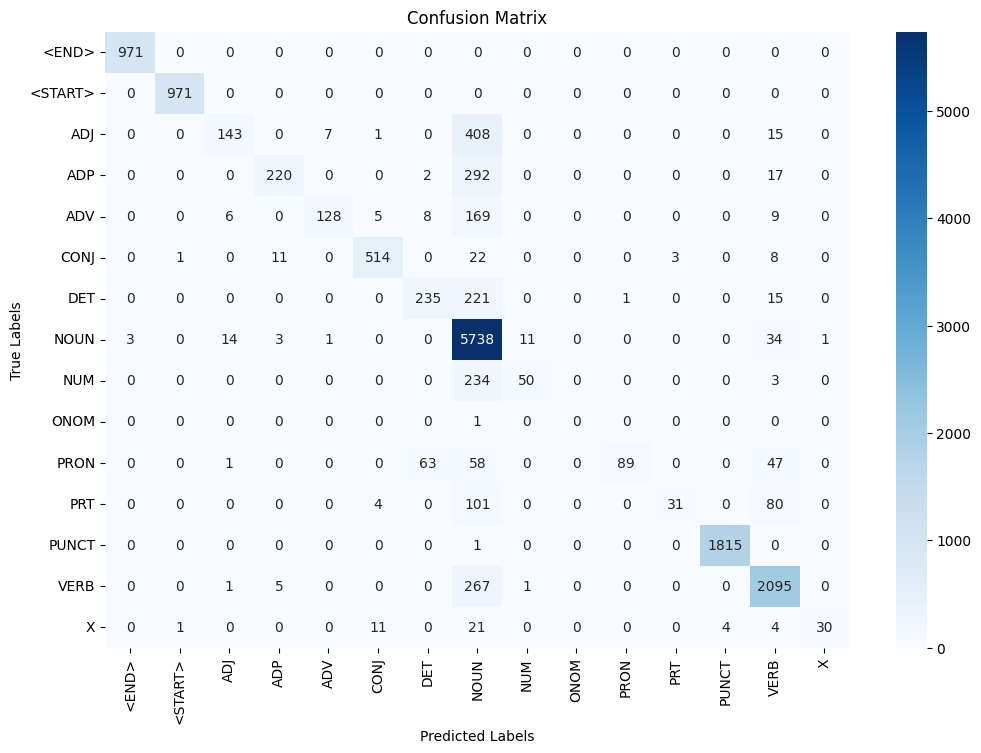

In [23]:
evaluate_predictions(predicted_tags)

In [24]:
predicted_tags_confined = viterbi(confined_test_data, transitions_conf, emissions_conf, tag_counts_conf, word_count_conf)

Accuracy: 0.91
F1 Score (weighted): 0.90

Classification Report:
              precision    recall  f1-score   support

         ADJ       0.87      0.23      0.37       574
         ADV       0.93      0.43      0.59       325
        NOUN       0.87      0.99      0.93      5805
       PUNCT       1.00      1.00      1.00      1816
        VERB       0.98      0.88      0.93      2369

    accuracy                           0.91     10889
   macro avg       0.93      0.71      0.76     10889
weighted avg       0.92      0.91      0.90     10889



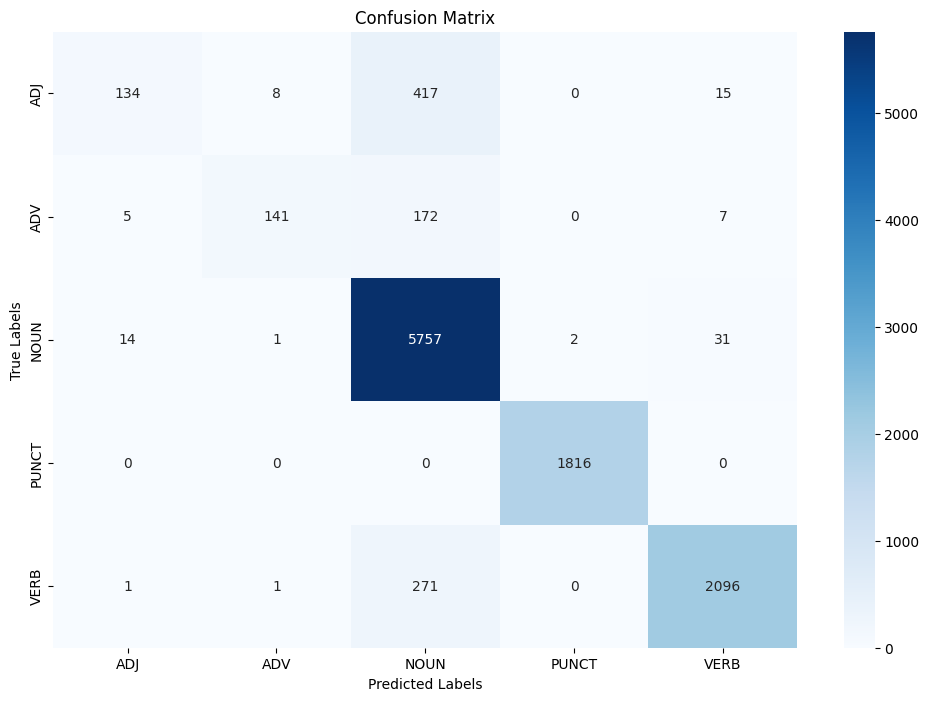

In [25]:
evaluate_predictions(predicted_tags_confined)

## 6. Explanation


## Assignment Report

### Data Preparation Method
The dataset was prepared by combining two Turkish treebank datasets, `web.conllu` and `wiki.conllu`. Both files were parsed using a custom `read_conll` function that extracts sentences in the form of word-tag pairs. Blank lines in the `.conllu` files marked sentence boundaries, while metadata lines starting with `#` were ignored. Sentences containing invalid or missing tokens were filtered out. The combined dataset was then split into training and test sets using an 80/20 split, with a fixed random seed to ensure reproducibility.

### Calculation of MLE Probabilities
The Hidden Markov Model’s transition and emission matrices were calculated using Maximum Likelihood Estimation (MLE):

- **Transition Probabilities**: These were computed by counting tag-to-tag transitions in the training data, normalized by the total occurrences of the originating tag.
- **Emission Probabilities**: These were calculated by counting the occurrences of a word given a specific tag, normalized by the total occurrences of that tag. Additive smoothing was applied to handle unseen transitions and emissions, ensuring numerical stability for rare or unknown words.

### Challenges Faced
1. **HMM Model Implementation**: Writing a fully functional HMM from scratch posed challenges in correctly handling edge cases, such as unknown words and rare transitions. The addition of `<START>` and `<END>` tags required adjustments to both the transition matrix and the Viterbi algorithm.
2. **Dataset Issues**: The dataset contained inconsistencies such as missing or malformed tokens. These had to be cleaned during preprocessing, which added complexity to the data preparation step.
3. **Performance Optimization**: The Viterbi algorithm was computationally intensive, especially for sentences with many words and tags. Optimizing the code for speed was critical to processing the test data efficiently.

### Performance Comments
The HMM POS tagger performed well on the test data:
- The model with all 14 tags achieved an accuracy of approximately **86%** and an F1 score of **83**.
- The reduced tag set (`ADJ, ADV, NOUN, VERB, PUNCT`) showed slightly better performance, with accuracy of **91%** and an F1 score of **90**, due to fewer ambiguous transitions and emissions.

The confusion matrix revealed that most errors occurred between semantically similar tags, such as NOUN and VERB, highlighting limitations in modeling complex linguistic structures with simple MLE-based HMMs.

### Limitations
1. **Handling of Unknown Words**: The model struggles with words that were not present in the training data, despite the use of smoothing.
2. **Simplistic Assumptions**: The HMM assumes independence between words given their tags, which fails to capture long-range dependencies or context in sentences.
3. **Tag Ambiguity**: Some POS tags overlap in usage, leading to errors in prediction.

### Possible Improvements
1. **Better Smoothing Techniques**: Advanced smoothing methods like Good-Turing or Kneser-Ney could improve handling of rare events.
2. **Word Embeddings**: Incorporating pre-trained embeddings (e.g., Word2Vec or FastText) for richer word representations could enhance emission probabilities.
3. **Higher-Order HMMs**: Extending to second-order HMMs may better capture dependencies between tags.
4. **Hybrid Models**: Combining HMMs with neural architectures (e.g., LSTMs or CRFs) could improve performance significantly while maintaining interpretability.
